In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import jax.random as random
from functools import partial
from typing import Callable, Union
from collections import namedtuple
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
import dill

from kernel import imq_kernel, rbf_kernel
from model import model
from methods import VGD
from experiment import experiment, diagnostic_experiment
from calculate_mmd import calculate_mmd_squared
from plot_functions import plot_predictives

/home/lqy_unix/Project_3_refactor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notes

1. Switch the problem from polynomials $f(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + ... + \theta_p x^p$ (they are unstable when $p$ gets large). Other options (which are fine):
   1. **Trigonemetric Functions** $f(x) = \theta_0 + \theta_1 \sin(x) + \ldots + \theta_p \sin(px)$.
   2. **Polynomial Basis:** E.g. Hermite: $f(x) = \theta_0 H_0(x) + \theta_1 H_1(x) + ... + \theta_p H_p(x)$ where $H_n$ is the $n$-th Hermite polynomial.
2. Thing to try: median heuristic for lengthscale ([this](https://github.com/MatthewAlexanderFisher/vgd/blob/main/src/vgd/methods/vgd.py) is how VGD implements it, [this](https://github.com/MatthewAlexanderFisher/vgd/blob/main/src/vgd/util.py) is the median heuristic code). This hopefully, will speed up convergence.
3. Ensure each misspecified experiment has the same level of **misspecification**. We can do this empirically via having an MMD cutoff between misspecified data and the true model data (or the predictions under the misspecified model).
4. We could consider more "faithful" higher dimensional experiments. E.g. don't have a polynomial basis but consider different covariates: $ y_i = \theta_0 + \theta_{11} x_{i1} + \theta_{12} x_{i2} + \theta_{21} x_{i1}^2 + \varepsilon_i$.

In [12]:
jnp.arange(1,2)

Array([1], dtype=int32)

## sin data

In [4]:
def f(theta, x):
  # f(x) = \theta_0 + \theta_1 \sin(x) + \ldots + \theta_p \sin(px)
  theta = jnp.asarray(theta)

  i_vals = jnp.arange(1, theta.shape[0]+1)
  # i_vals[:, None] shape (p, 1)
  # x               shape (n_data,)
  # broadcast product shape (p, n_data)
  products = i_vals[:, None] * x
  
  # vector of sin termes: [sin(1*x), sin(2*x), ..., sin(p*x)]
  sin_terms = jnp.sin(products)
  
  # sum(theta_i * sin(i*x))
  sum_term = jnp.sum(theta[:, None] * sin_terms, axis=0)
  
  return sum_term

def sin_inverse(x):
    return jnp.sin(1/x)

f_jit = jit(f)

a = jnp.tile(jnp.array([-1, 1]), 25)


sigma = 0.2
sine_model_1 = model(sigma, f_jit, theta_dim=1)
sine_model_2 = model(sigma, f_jit, theta_dim=3)
sine_model_5 = model(sigma, f_jit, theta_dim=5)
sine_model_6 = model(sigma, f_jit, theta_dim=7)
sine_model_10 = model(sigma, f_jit, theta_dim=10)
sine_model_11 = model(sigma, f_jit, theta_dim=12)
sine_model_20 = model(sigma, f_jit, theta_dim=20)
sine_model_50 = model(sigma, f_jit, theta_dim=50)


theta_1 = a[0:1]
theta_2 = a[0:3]
theta_5 = a[0:5]
theta_6 = a[0:7]
theta_10 = a[0:10]
theta_11 = a[0:12]
theta_20 = a[0:20]
theta_50 = a[0:50]

n_data = 1000
key = random.PRNGKey(10)
data_1_w = sine_model_1.generate_data(n_data, theta_1, x_max=2.0, x_min=-2.0, key=key)
data_1_m = sine_model_2.generate_data(n_data, theta_2, x_max=2.0, x_min=-2.0, key=key)
data_5_w = sine_model_5.generate_data(n_data, theta_5, x_max=2.0, x_min=-2.0, key=key)
data_5_m = sine_model_6.generate_data(n_data, theta_6, x_max=2.0, x_min=-2.0, key=key)
data_10_w = sine_model_10.generate_data(n_data, theta_10, x_max=2.0, x_min=-2.0, key=key)
data_10_m = sine_model_11.generate_data(n_data, theta_11, x_max=2.0, x_min=-2.0, key=key)
data_20_w = sine_model_20.generate_data(n_data, theta_20, x_max=2.0, x_min=-2.0, key=key)
data_50_w = sine_model_50.generate_data(n_data, theta_50, x_max=2.0, x_min=-2.0, key=key)

data_inverse = (data_1_w[0], sin_inverse(data_1_w[0])+0.2*random.normal(key, shape=data_1_w[1].shape))

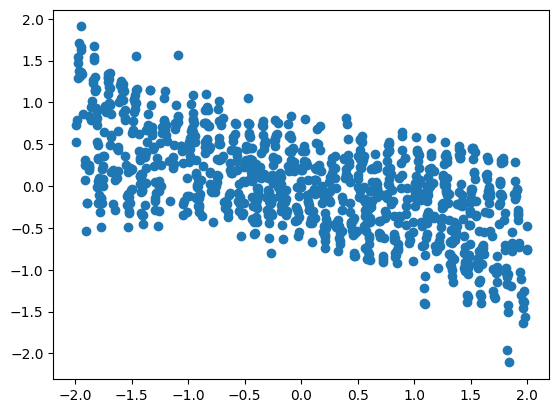

In [12]:
plt.scatter(*data_50_w)

## 1 well

In [19]:
experiment_1_w = experiment(sine_model_1, data_1_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_1_w.run(n_steps=10000, step_size=0.0001)

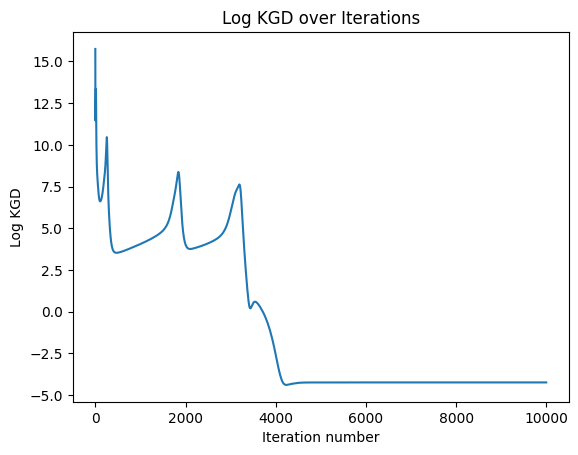

In [20]:
experiment_1_w.plot_KGD()

In [21]:
experiment_1_w.particles_SVGD.mean()

Array(-0.9984196, dtype=float32)

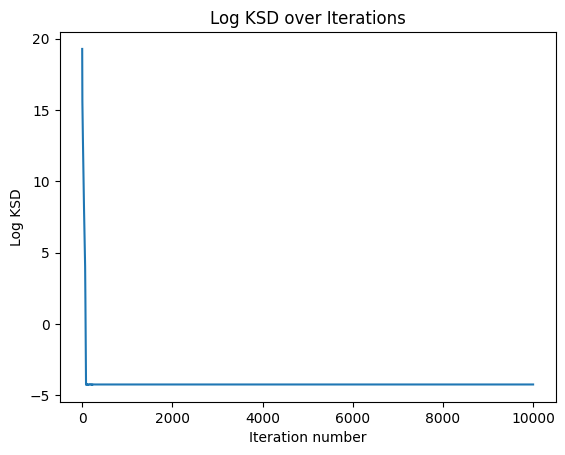

In [22]:
experiment_1_w.plot_KSD()

MMD length scale: 0.77164906
Actual mmd 3.1903255e-06


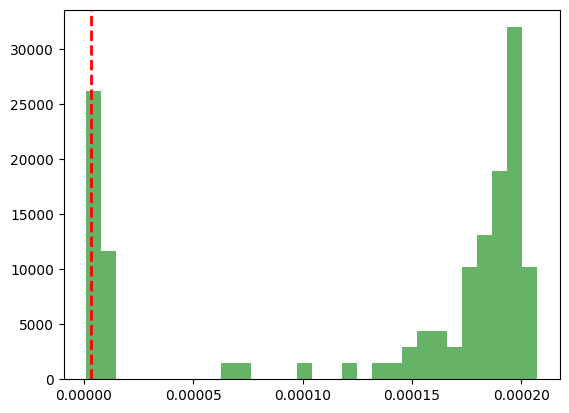

In [23]:
diagnostic_experiment_1_w = diagnostic_experiment(experiment_1_w)
all_mmd_values_1_w, actual_mmd_1_w = diagnostic_experiment_1_w.plot_diagnostic()

## 1 mis

In [27]:
experiment_1_m = experiment(sine_model_1, data_inverse, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_1_m.run(n_steps=10000, step_size=0.0001)

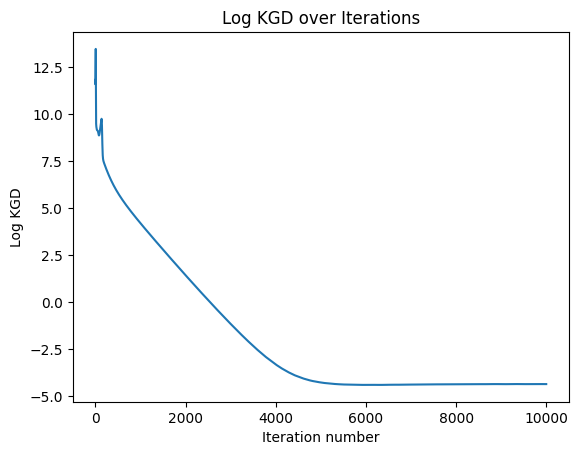

In [28]:
experiment_1_m.plot_KGD()

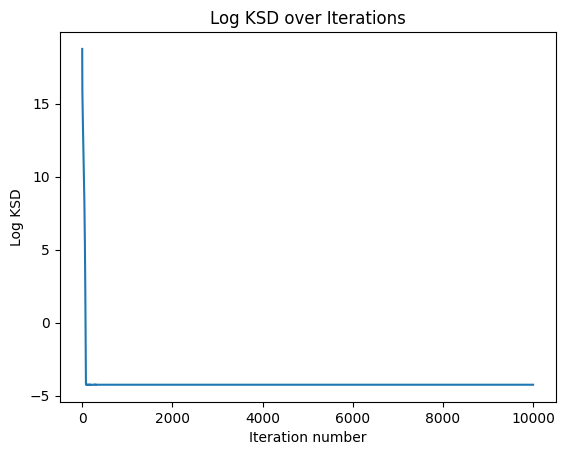

In [29]:
experiment_1_m.plot_KSD()

In [18]:
experiment_1_m.particles_VGD.mean(axis=0)

Array([-0.9678165 , -0.44244614], dtype=float32)

MMD length scale: 1.0254999
Actual mmd 0.00065587735


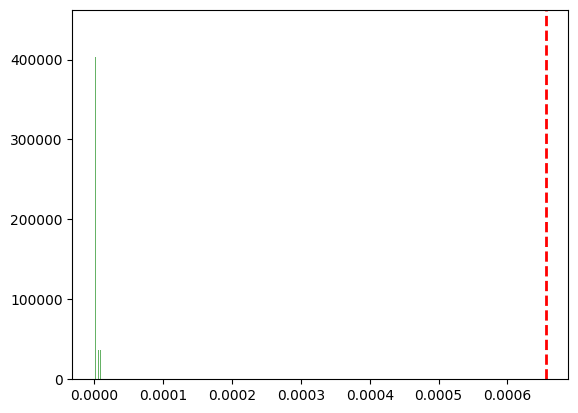

In [31]:
diagnostic_experiment_1_m = diagnostic_experiment(experiment_1_m)
all_mmd_values_1_m, actual_mmd_1_m = diagnostic_experiment_1_m.plot_diagnostic()

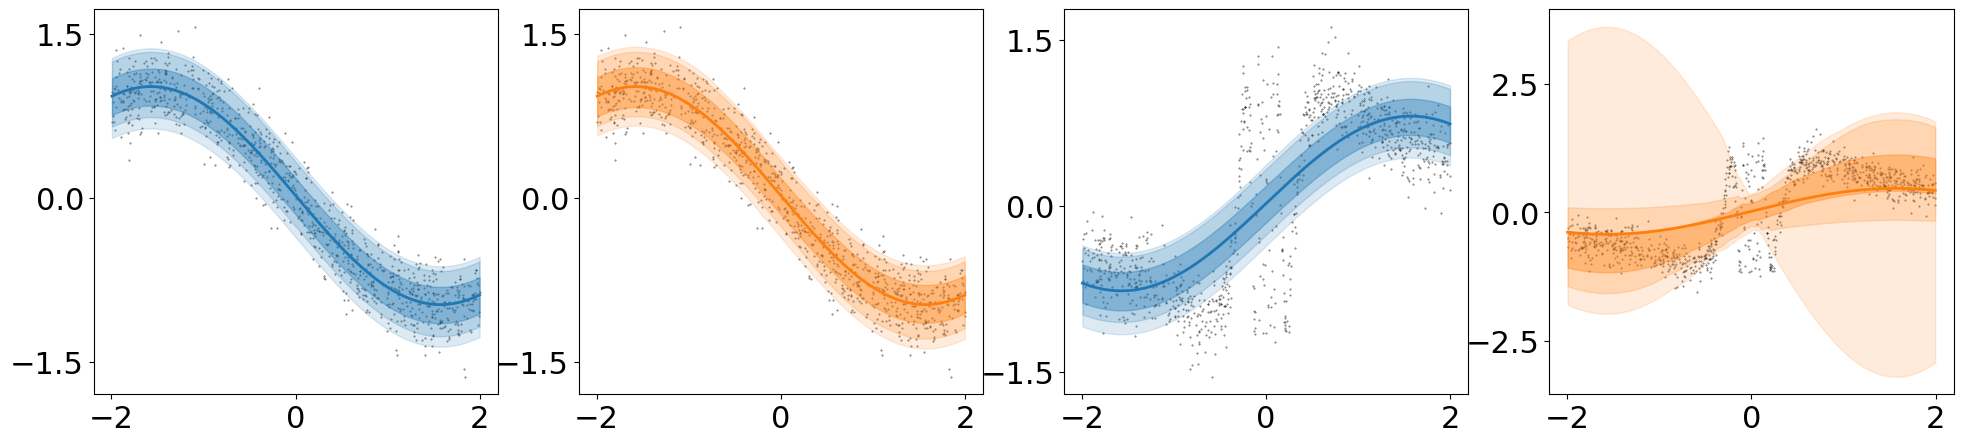

In [30]:
plot_predictives(
    experiment_1_w,
    experiment_1_m, 
    intervals=[50, 80, 90]
)

## 5 well

In [9]:
experiment_5_w = experiment(sine_model_5, data_5_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_5_w.run(n_steps=15000, step_size=0.0001)

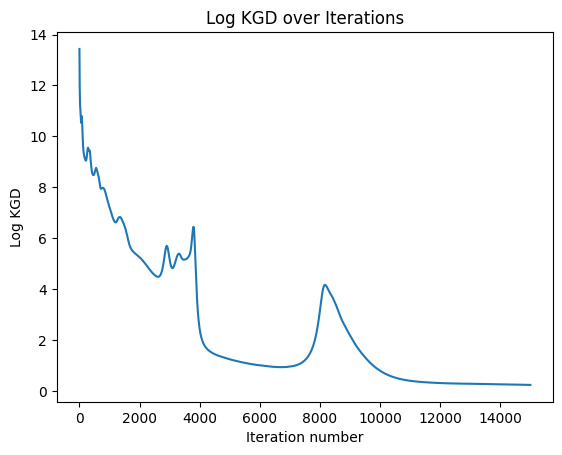

In [18]:
experiment_5_w.plot_KGD()

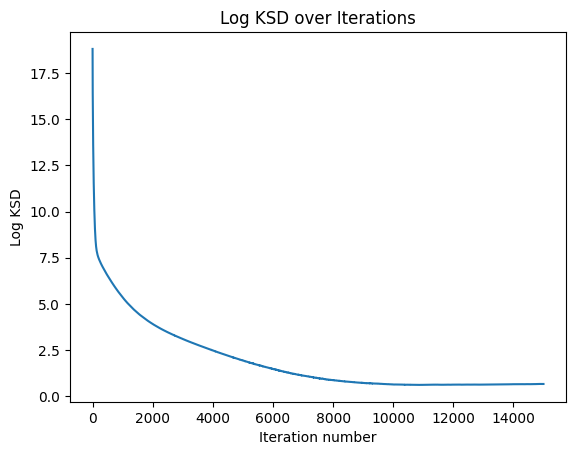

In [19]:
experiment_5_w.plot_KSD()

In [20]:
experiment_5_w.particles_SVGD.mean(axis=0)

Array([-0.967048  ,  0.94774723, -0.96598816,  0.96777934, -0.99781626],      dtype=float32)

In [44]:
experiment_5_w.particles_VGD.mean(axis=0)

Array([-0.9585686 ,  0.934851  , -0.9527759 ,  0.95923895, -0.99444926],      dtype=float32)

MMD length scale: 0.5732680137449404
Actual mmd 2.146138659362049e-05


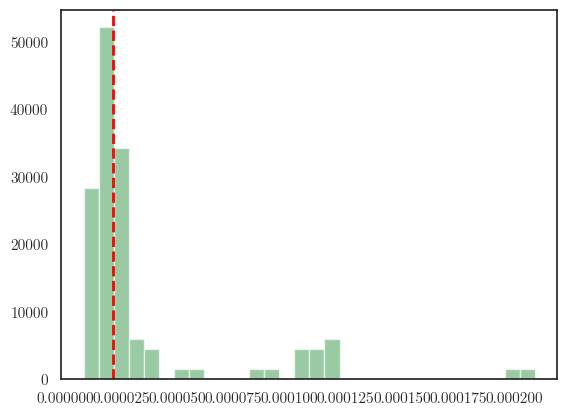

In [10]:
diagnostic_experiment_5_w = diagnostic_experiment(experiment_5_w)
all_mmd_values_5_w, actual_mmd_5_w = diagnostic_experiment_5_w.plot_diagnostic(parallel=False, trajectory=False)

## 5 mis

In [3]:
experiment_5_m = experiment(sine_model_5, data_inverse, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_5_m.run(n_steps=15000, step_size=0.0001)

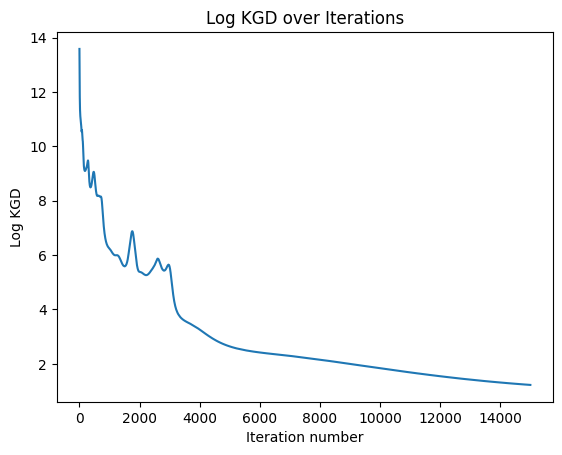

In [25]:
experiment_5_m.plot_KGD()

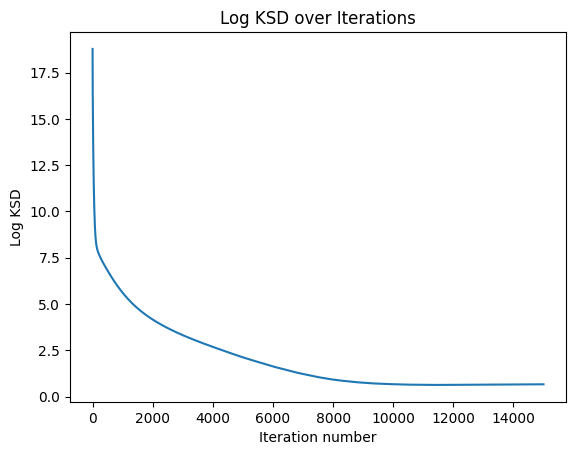

In [51]:
experiment_5_m.plot_KSD()

MMD length scale: 0.87557095
Actual mmd 0.00057478924


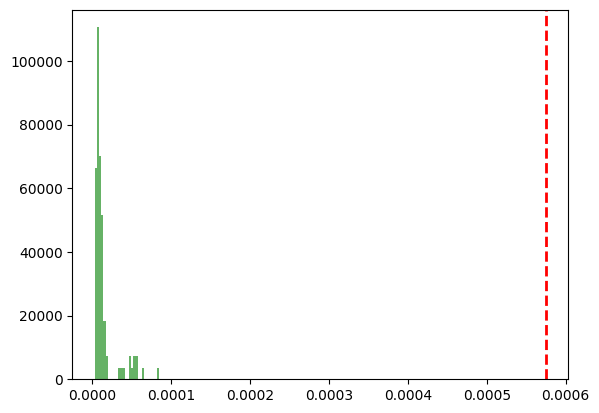

In [4]:
diagnostic_experiment_5_m = diagnostic_experiment(experiment_5_m)
all_mmd_values_5_m, actual_mmd_5_m = diagnostic_experiment_5_m.plot_diagnostic(parallel=False, trajectory=False)

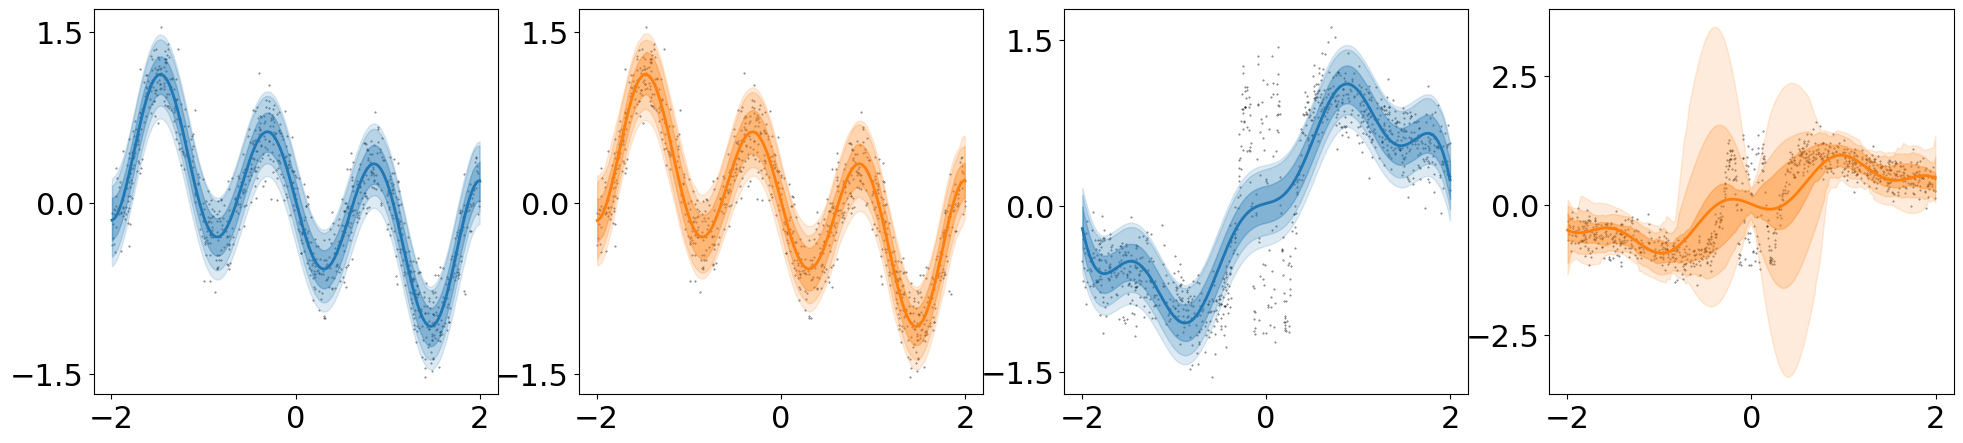

In [26]:
plot_predictives(
    experiment_5_w,
    experiment_5_m, 
    intervals=[50, 80, 90]
)

## 10 well

In [53]:
experiment_10_w = experiment(sine_model_10, data_10_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_10_w.run(n_steps=20000, step_size=0.0001)

In [54]:
experiment_10_w.particles_SVGD.mean(axis=0)

Array([-0.5461018 ,  0.15508267,  0.09117313, -0.1957472 ,  0.09230975,
        0.12905245, -0.42582127,  0.6853358 , -0.8875732 ,  0.96955824],      dtype=float32)

In [55]:
experiment_10_w.particles_VGD.mean(axis=0)

Array([-0.49539265,  0.10347761,  0.09209642, -0.13836367,  0.01537804,
        0.17623423, -0.42554775,  0.65732783, -0.86050004,  0.9570865 ],      dtype=float32)

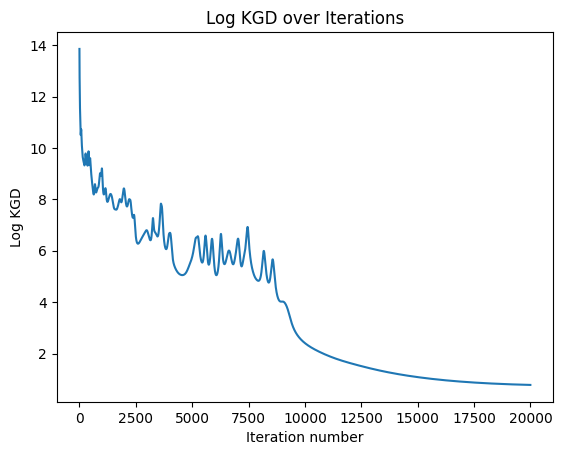

In [56]:
experiment_10_w.plot_KGD()

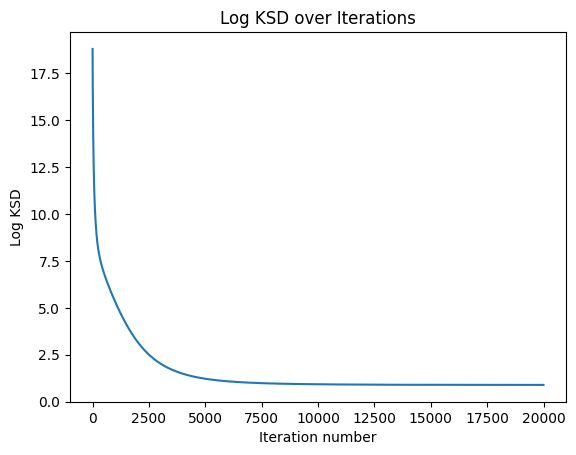

In [57]:
experiment_10_w.plot_KSD()

In [36]:
diagnostic_experiment_10_w = diagnostic_experiment(experiment_10_w)
all_mmd_values_10_w, actual_mmd_10_w = diagnostic_experiment_10_w.plot_diagnostic()

W1117 10:32:50.051861    2340 bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.64GiB (rounded to 1760000000)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
W1117 10:32:50.052195    2340 bfc_allocator.cc:512] *____________*****__**************______******************************************************______
E1117 10:32:50.052222    2340 pjrt_stream_executor_client.cc:2974] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1760000000 bytes. [tf-allocator-allocation-error='']


JaxRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1760000000 bytes.

## 10 mis

In [58]:
experiment_10_m = experiment(sine_model_10, data_inverse, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_10_m.run(n_steps=20000, step_size=1e-4)

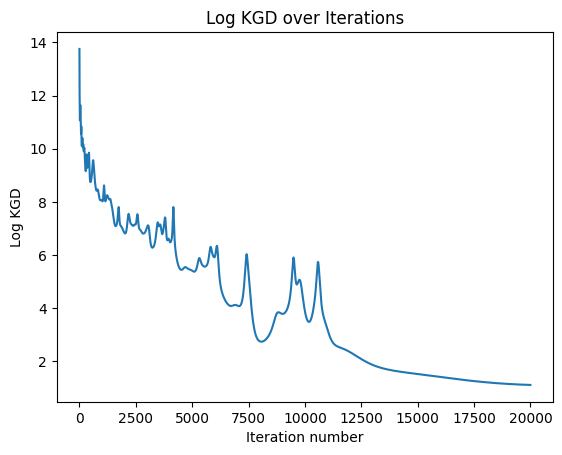

In [59]:
experiment_10_m.plot_KGD()

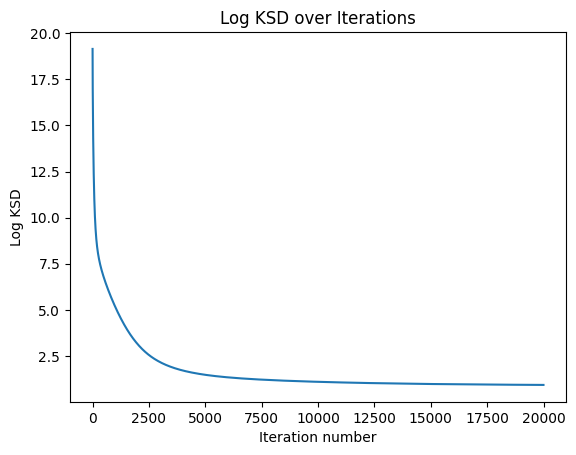

In [60]:
experiment_10_m.plot_KSD()

MMD length scale: 0.8480092
Actual mmd 0.00037356646


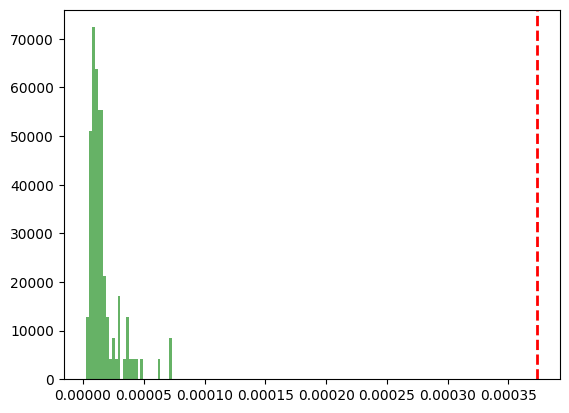

In [62]:
diagnostic_experiment_10_m = diagnostic_experiment(experiment_10_m)
all_mmd_values_10_m, actual_mmd_10_m = diagnostic_experiment_10_m.plot_diagnostic()

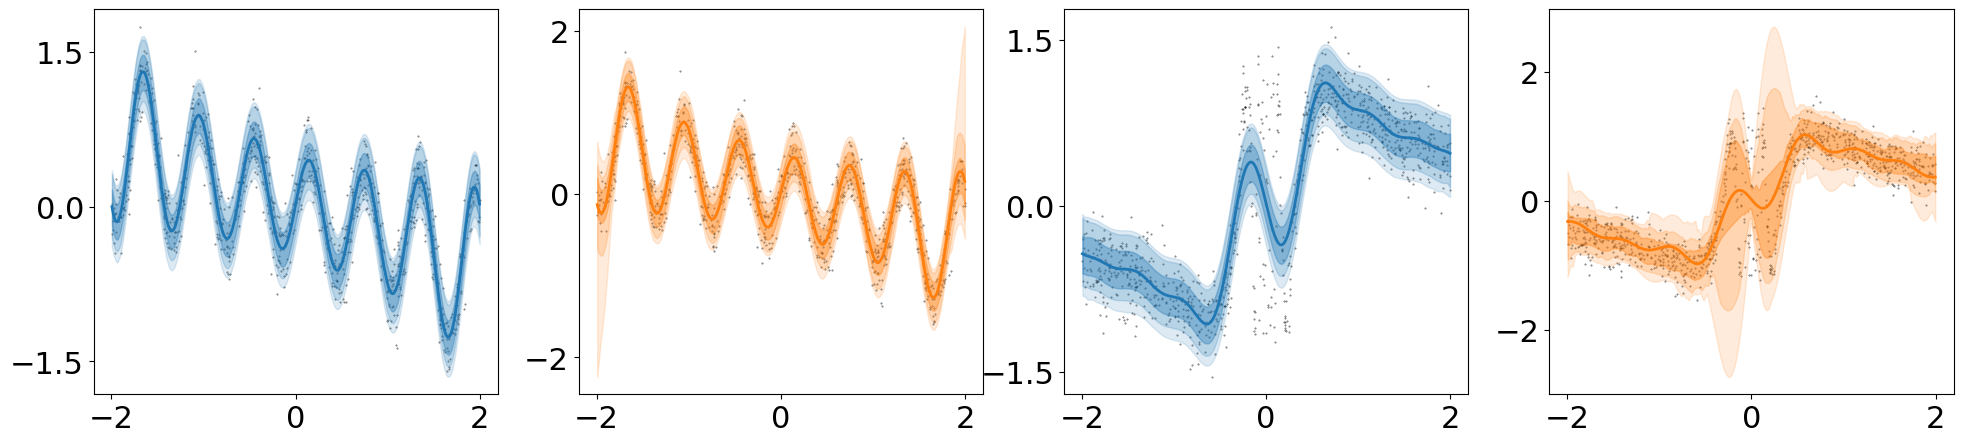

In [61]:
plot_predictives(
    experiment_10_w,
    experiment_10_m,
    intervals=[50, 80, 90]
)

## 20 well

In [5]:
experiment_20_w = experiment(sine_model_20, data_20_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_20_w.run(n_steps=60000, step_size=0.0001)

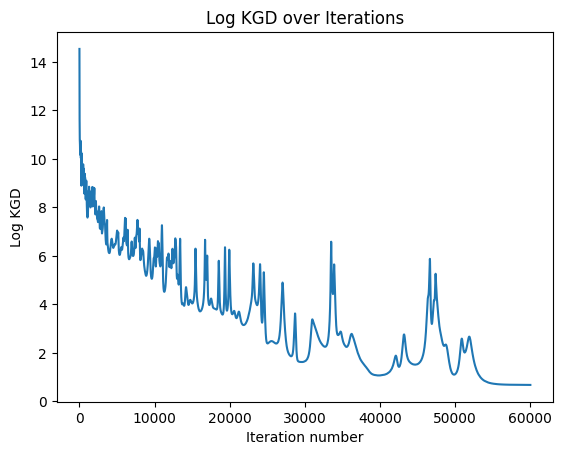

In [6]:
experiment_20_w.plot_KGD()

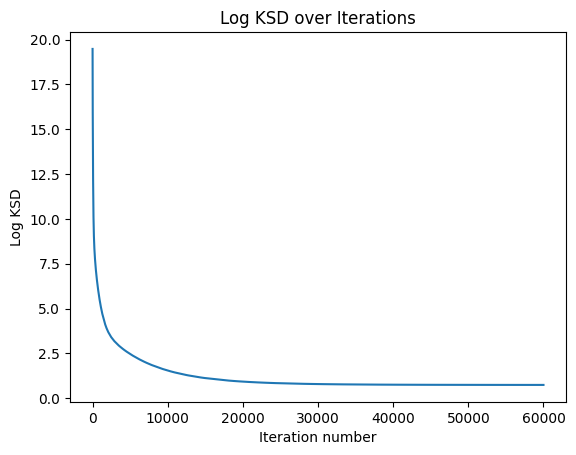

In [13]:
experiment_20_w.plot_KSD()

In [14]:
experiment_20_w.particles_VGD.mean(axis=0)

Array([-0.34965894, -0.06311474,  0.13625179, -0.03690859, -0.09216774,
        0.07217705,  0.02803667, -0.10319088,  0.03431958,  0.07893106,
       -0.14384931,  0.06137681,  0.11663069, -0.22638929,  0.14835005,
        0.15792729, -0.52460617,  0.8248523 , -0.9813504 ,  1.0104083 ],      dtype=float32)

MMD length scale: 0.5775194
Actual mmd 3.804457e-05


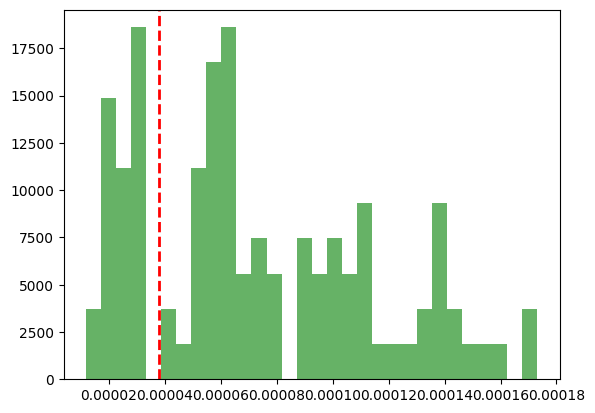

In [7]:
diagnostic_experiment_20_w = diagnostic_experiment(experiment_20_w)
all_mmd_values_20_w, actual_mmd_20_w = diagnostic_experiment_20_w.plot_diagnostic(parallel=False, trajectory=False)

## 20 mis

In [8]:
experiment_20_m = experiment(sine_model_20, data_inverse, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_20_m.run(n_steps=50000, step_size=0.0001)

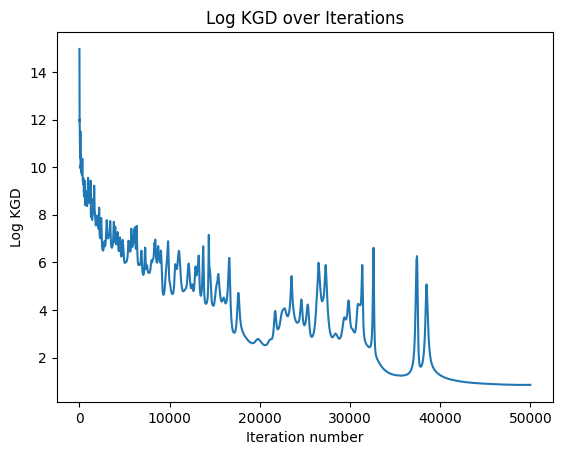

In [18]:
experiment_20_m.plot_KGD()

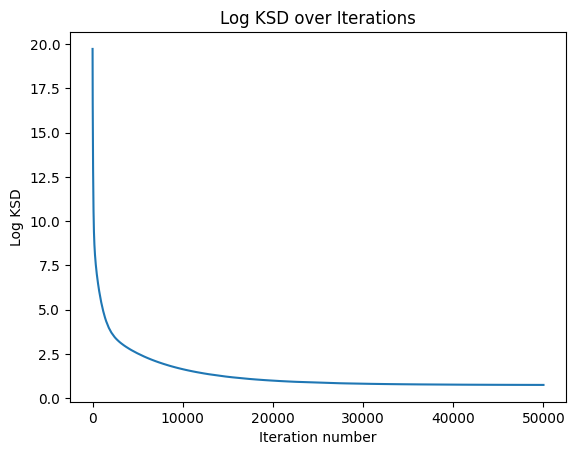

In [19]:
experiment_20_m.plot_KSD()

MMD length scale: 0.94449395
Actual mmd 0.0004536405


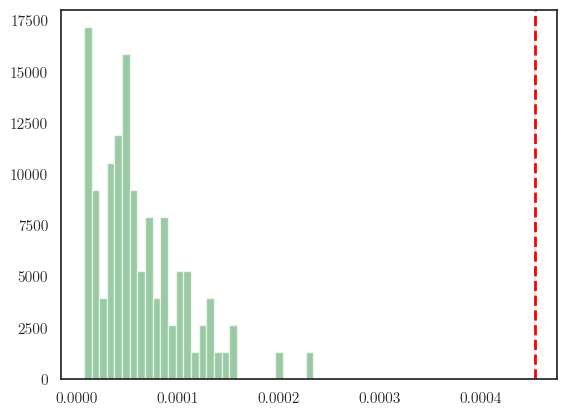

In [12]:
diagnostic_experiment_20_m = diagnostic_experiment(experiment_20_m)
all_mmd_values_20_m, actual_mmd_20_m = diagnostic_experiment_20_m.plot_diagnostic(parallel=False, trajectory=False)

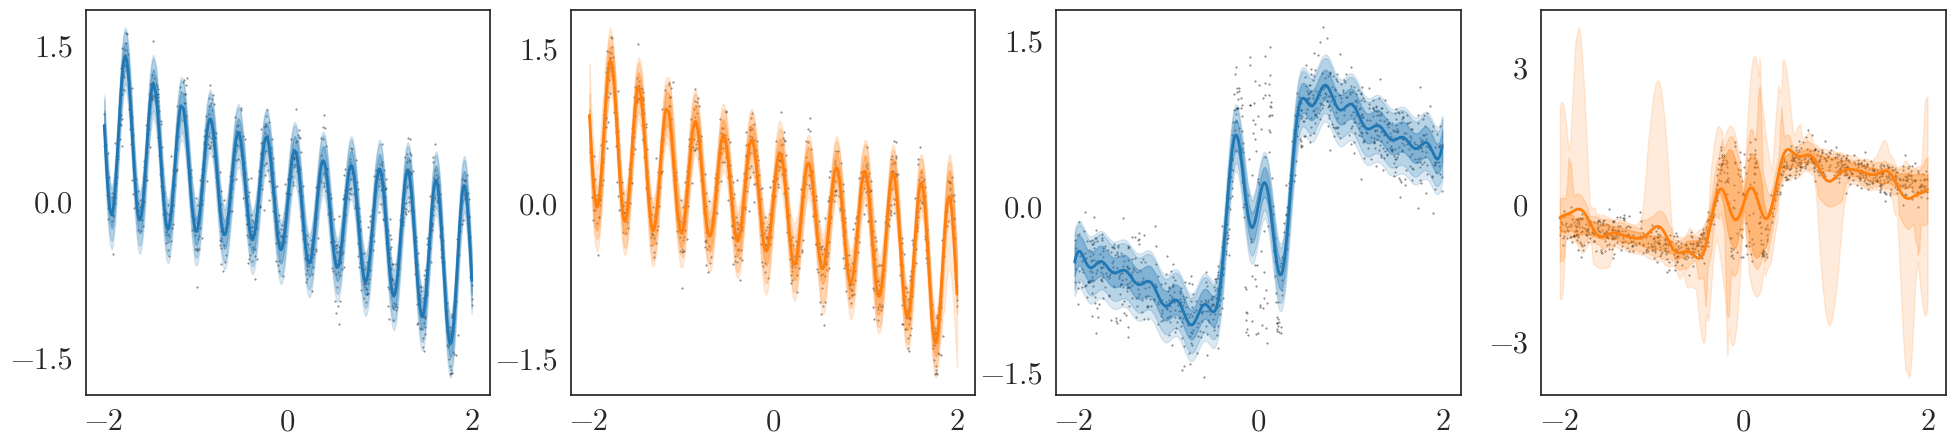

In [13]:
plot_predictives(
    experiment_20_w,
    experiment_20_m, 
    intervals=[50, 80, 90]
)

## 50 well

In [3]:
experiment_50_w = experiment(sine_model_50, data_50_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_50_w.run(n_steps=100000, step_size=0.0001)

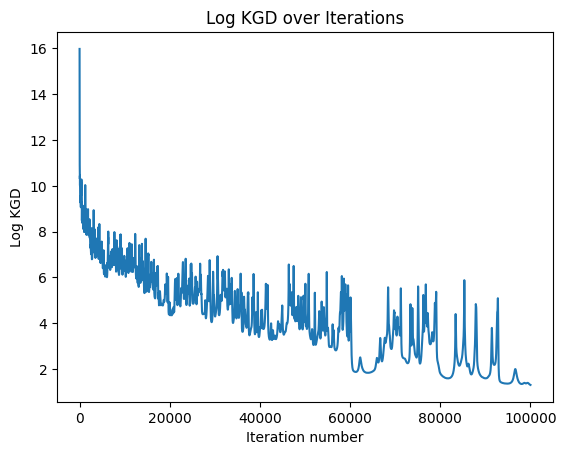

In [4]:
experiment_50_w.plot_KGD()

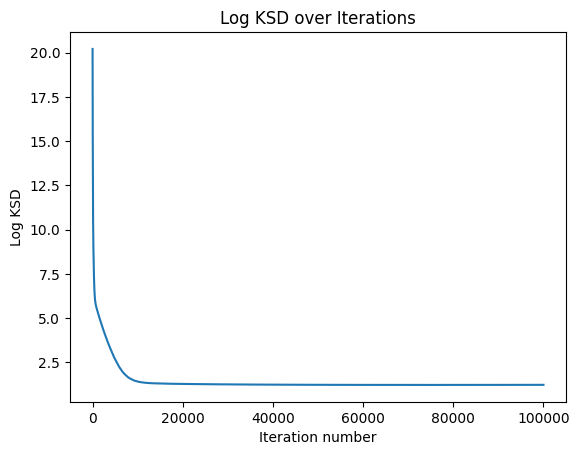

In [5]:
experiment_50_w.plot_KSD()

MMD length scale: 0.78373176
Actual mmd 0.00016256164


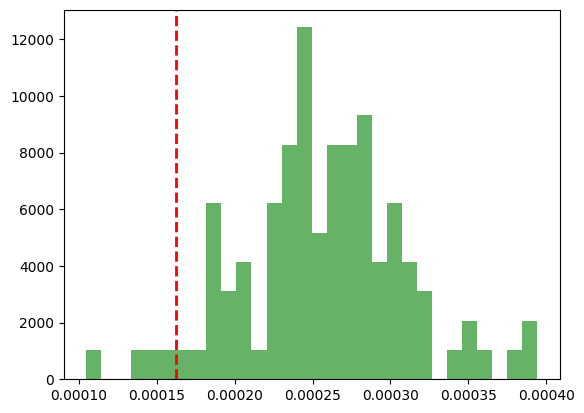

In [6]:
diagnostic_experiment_50_w = diagnostic_experiment(experiment_50_w)
all_mmd_values_50_w, actual_mmd_50_w = diagnostic_experiment_50_w.plot_diagnostic(parallel=False, trajectory=False)

## 50 mis

In [3]:
experiment_50_m = experiment(sine_model_50, data_inverse, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_50_m.run(n_steps=100000, step_size=0.0001)

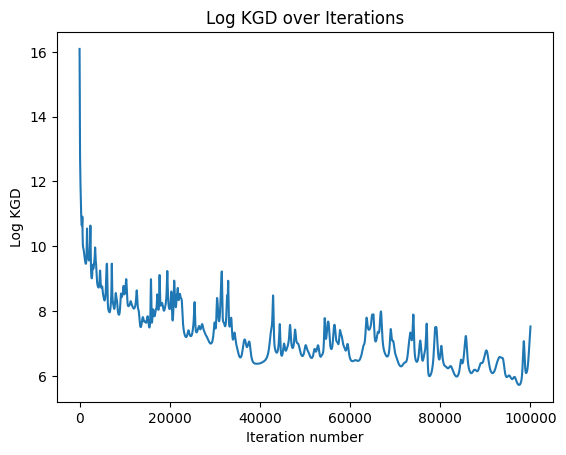

In [14]:
experiment_50_m.plot_KGD()

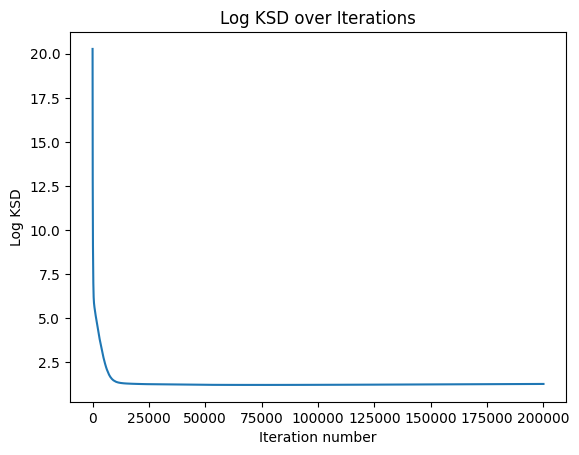

In [5]:
experiment_50_m.plot_KSD()

MMD length scale: 1.2860651
Actual mmd 0.00048035284


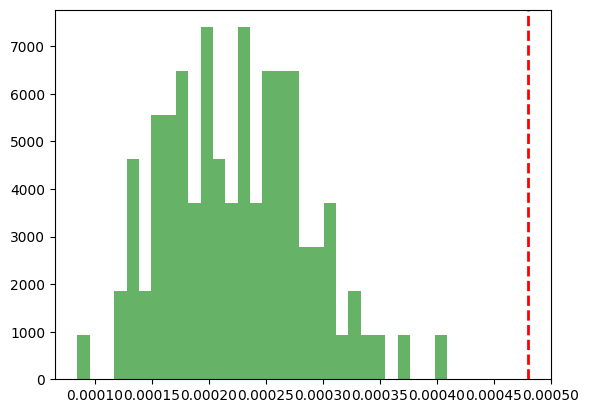

In [4]:
diagnostic_experiment_50_m = diagnostic_experiment(experiment_50_m)
all_mmd_values_50_m, actual_mmd_50_m = diagnostic_experiment_50_m.plot_diagnostic(parallel=False, trajectory=False)

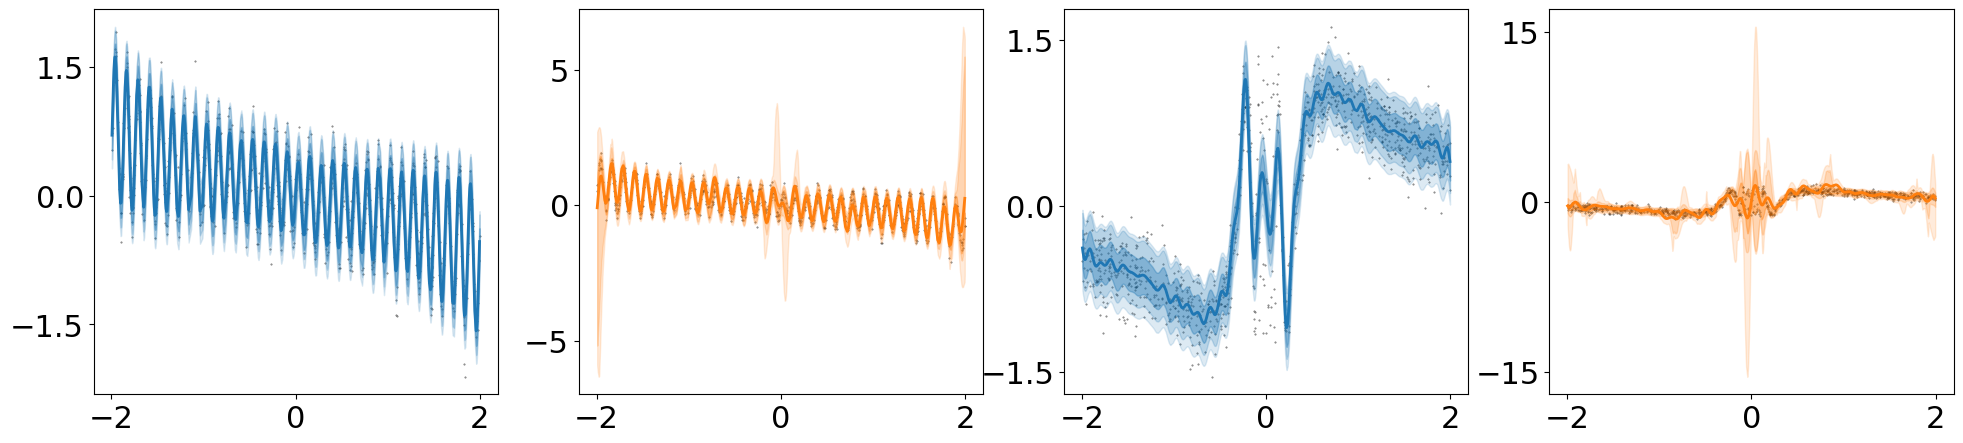

In [9]:
plot_predictives(
    experiment_50_w,
    experiment_50_m, 
    intervals=[50, 80, 90]
)

## save data

In [23]:
import dill
data_to_save = {
    'experiment_20_w': experiment_20_w,
    'all_mmd_values_20_w': all_mmd_values_20_w,
    'actual_mmd_20_w': actual_mmd_20_w,
    'experiment_20_m': experiment_20_m,
    'all_mmd_values_20_m': all_mmd_values_20_m,
    'actual_mmd_20_m': actual_mmd_20_m,
    'experiment_50_w': experiment_50_w,
    'all_mmd_values_50_w': all_mmd_values_50_w,
    'actual_mmd_50_w': actual_mmd_50_w,
    'experiment_50_m': experiment_50_m,
    'all_mmd_values_50_m': all_mmd_values_50_m,
    'actual_mmd_50_m': actual_mmd_50_m
}
with open('sine_different_dimension_experiments.pkl', 'wb') as f:
    dill.dump(data_to_save, f)

In [14]:
import dill
try:
    with open('sine_different_dimension_experiments.dill', 'rb') as f:
        data_to_save = dill.load(f)
    print("加载成功：旧的字典已读入内存。")
except FileNotFoundError:
    print("警告：未找到旧文件。将创建一个新的字典。")
    data_to_save = {}

data_to_save['experiment_20_m'] = experiment_20_m
data_to_save['all_mmd_values_20_m'] = all_mmd_values_20_m
data_to_save['actual_mmd_20_m'] = actual_mmd_20_m

with open('sine_different_dimension_experiments.dill', 'wb') as f:
    dill.dump(data_to_save, f)

加载成功：旧的字典已读入内存。


In [6]:
with open('sine_different_dimension_experiments.dill', 'rb') as f:
    data = dill.load(f)

In [21]:
data_to_save.keys()

dict_keys(['experiment_20_w', 'all_mmd_values_20_w', 'actual_mmd_20_w', 'experiment_20_m', 'all_mmd_values_20_m', 'actual_mmd_20_m', 'experiment_50_w', 'all_mmd_values_50_w', 'actual_mmd_50_w', 'experiment_50_m', 'all_mmd_values_50_m', 'actual_mmd_50_m', 'experiment_5_m', 'all_mmd_values_5_m', 'actual_mmd_5_m', 'experiment_5_w', 'all_mmd_values_5_w', 'actual_mmd_5_w'])

## plot

In [ ]:
from plot_functions import predictive_posterior_distribution_k, plot_shaded_region_predictive, plot_diagnostic, plot_diagnostic_manual_broken

def plot_main_figure(file_name='main_fig.dill'):
    sns.set_theme(
    style="white",
    rc={
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman", "CMU Serif", "Times New Roman"],
        "mathtext.fontset": "cm",
        "legend.frameon": True
    }
    )
    # -----------------------------------------------------------

    jax.config.update("jax_enable_x64", True)
    try:
        with open(file_name, 'rb') as f:
            data = dill.load(f)
        print(f"成功加载文件，包含 {len(data.keys())} 个数组: {list(data.keys())}")
    except FileNotFoundError:
        print(fr"错误：'{file_name}' 文件未找到。")
        exit()

    # --- 3. 自动化绘图 ---
    col_widths = [1, 1, 1, 1, 1, 0.75 + 0.25] 
    row_heights = [1, 1, 1]
    nested_col_widths = [0.75, 0.25]

    # --- 创建图像 ---
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 12.5))
    main_gs = fig.add_gridspec(
        nrows=3, 
        ncols=6, 
        height_ratios=row_heights,
        width_ratios=col_widths
    )
        
    data_prefixes = ['5', '20', '50']
    # row_titles = ['Quadratic', 'Sigmoid', '2D Quadratic']
    row_titles = [r'$\mathrm{d=5}$', r'$\mathrm{d=20}$', r'$\mathrm{d=50}$']
    VGD_color = '#ff7f0e'
    SVGD_color = '#1f77b4'

    for row_idx, prefix in enumerate(data_prefixes):
        experiment_w = data[f'experiment_{prefix}_w']

        all_mmd_values_w = data[f'all_mmd_values_{prefix}_w']
        actual_mmd_w = data[f'actual_mmd_{prefix}_w'].item()

        plot_shaded_region_predictive(axes[row_idx, 0], experiment_w, experiment_w.particles_SVGD, SVGD_color)
        plot_shaded_region_predictive(axes[row_idx, 1], experiment_w, experiment_w.particles_VGD, VGD_color)
        axes[row_idx, 1].yaxis.set_ticks_position('none')
        plt.setp(axes[row_idx, 1].get_yticklabels(), visible=False)

        ax = axes[row_idx, 2]
        plot_diagnostic(ax, all_mmd_values=all_mmd_values_w, actual_mmd=actual_mmd_w)

        experiment_m = data[f'experiment_{prefix}_m']

        all_mmd_values_m = data[f'all_mmd_values_{prefix}_m']
        actual_mmd_m = data[f'actual_mmd_{prefix}_m'].item()

        plot_shaded_region_predictive(axes[row_idx, 3], experiment_m, experiment_m.particles_SVGD, SVGD_color)
        plot_shaded_region_predictive(axes[row_idx, 4], experiment_m, experiment_m.particles_VGD, VGD_color)
        axes[row_idx, 4].yaxis.set_ticks_position('none')
        plt.setp(axes[row_idx, 4].get_yticklabels(), visible=False)

        ax = axes[row_idx, 5]
        plot_diagnostic(ax, all_mmd_values=all_mmd_values_m, actual_mmd=actual_mmd_m)


        y_lim_w_svgd = axes[row_idx, 0].get_ylim()
        axes[row_idx, 1].set_ylim(y_lim_w_svgd)
        y_lim_m_svgd = axes[row_idx, 3].get_ylim()
        axes[row_idx, 4].set_ylim(y_lim_m_svgd)
        
    # --- 4. 调整布局 ---
    plt.tight_layout(rect=[0.05, 0, 1, 0.93])

    # --- 5. 添加全局标题和标签 ---
    col_titles = [r'$P_\mathrm{Bayes}$', r'$P_\mathrm{PrO}$', r'$\mathrm{MMD}$', r'$P_\mathrm{Bayes}$', r'$P_\mathrm{PrO}$', r'$\mathrm{MMD}$']
    for i, title in enumerate(col_titles):
        if title:
            x_coord = (axes[0, i].get_position().x0 + axes[0, i].get_position().x1) / 2
            fig.text(x_coord, 0.96, title, ha='center', va='top', fontsize=28)

    for i, title in enumerate(row_titles):
        y_coord = (axes[i, 0].get_position().y0 + axes[i, 0].get_position().y1) / 2
        fig.text(0.02, y_coord, title, ha='left', va='center', fontsize=28, rotation=90)


    # --- 6. 显示图像 ---
    fig.subplots_adjust(
        wspace=0.16,   # 水平间距
        hspace=0.12    # 垂直间距
    )
    plt.show()

成功加载文件，包含 18 个数组: ['experiment_20_w', 'all_mmd_values_20_w', 'actual_mmd_20_w', 'experiment_20_m', 'all_mmd_values_20_m', 'actual_mmd_20_m', 'experiment_50_w', 'all_mmd_values_50_w', 'actual_mmd_50_w', 'experiment_50_m', 'all_mmd_values_50_m', 'actual_mmd_50_m', 'experiment_5_m', 'all_mmd_values_5_m', 'actual_mmd_5_m', 'experiment_5_w', 'all_mmd_values_5_w', 'actual_mmd_5_w']
Actual mmd 2.1461386495502666e-05
Actual mmd 0.0005747892428189516
Actual mmd 3.804457082878798e-05
Actual mmd 0.0006596445455215871
Actual mmd 0.00016256164235528558
Actual mmd 0.0004803528427146375


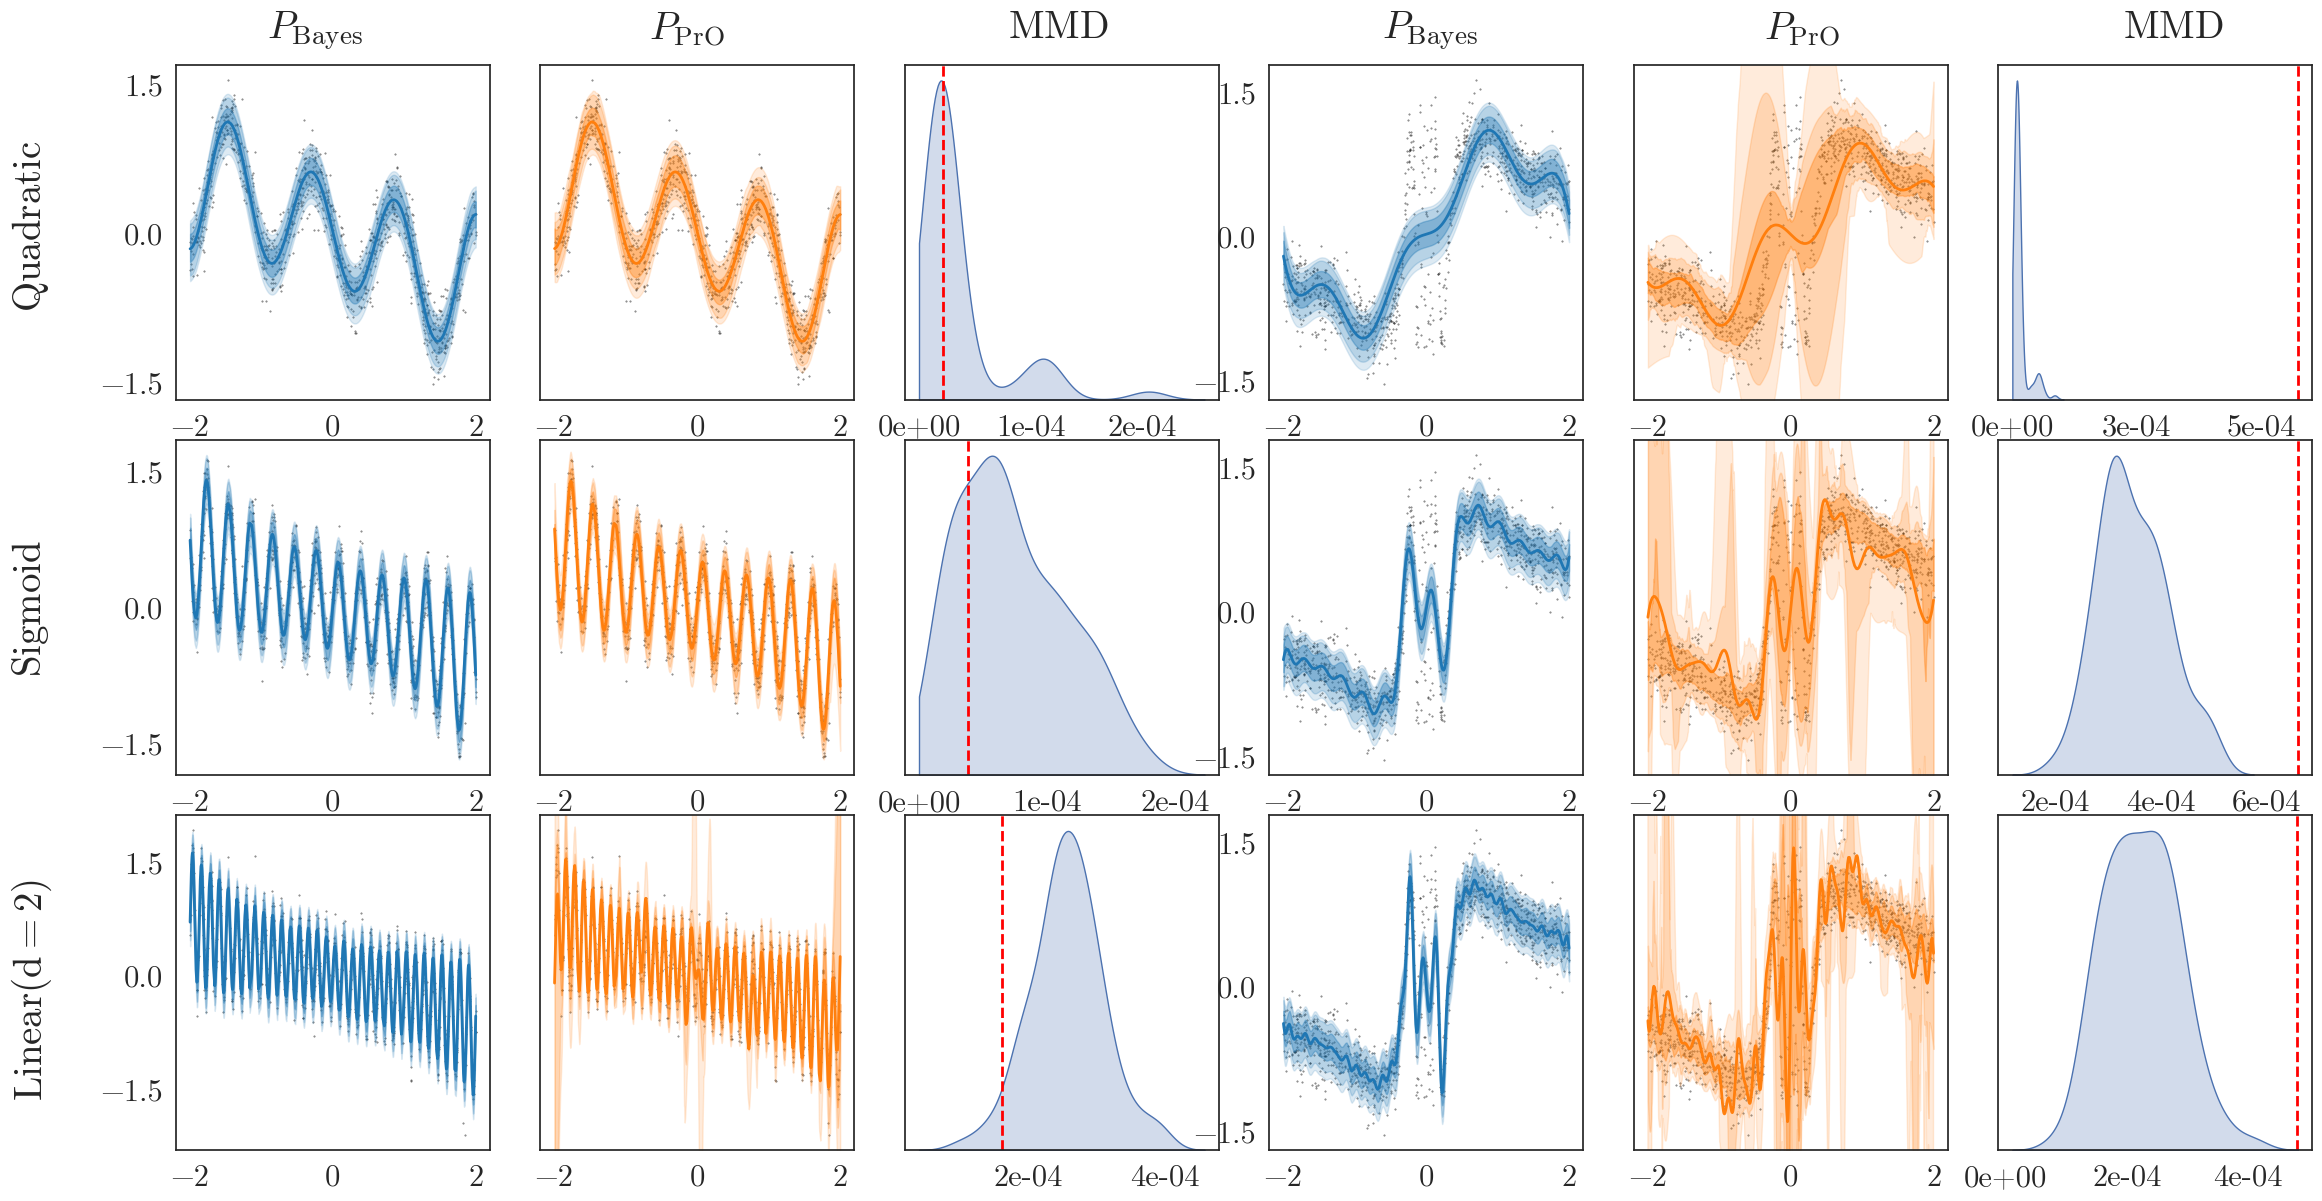

In [11]:
plot_main_figure('sine_different_dimension_experiments.dill')